In [1]:
#%xmode Verbose

In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from utils import shift_join_data, mae,rmse,mape,print_line, plot_pred, plot_history
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import datetime

Using TensorFlow backend.


In [3]:
# Ruta del modelo con hiperparametros optimizados (sin entrenar)
model_path = '../modelamiento/ajustes/Seq2Seq_20220724_2143.h5'
# Callback para detener el entrenamiento cuando el error de validacion no disminuye despues de 50 epocas
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)
mini_batch = 32
n_epochs= 2000  # Nro de epocas maximas
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
res_name = 'resultados/Seq2Seq_'+fecha_hora
n_iter = 30

# Carga de datos

In [4]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

Paises

In [5]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [5]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]
df_test = df.copy()


Países de Entrenamiento

In [8]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features de Entrenamiento

In [9]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


# Normalizar

In [6]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-3,3)
df_y_train.iloc[:,:] = np.clip(df_y_train,-3,3)
df_x_test.iloc[:,:] = np.clip(df_x_test,-3,3)
df_y_test.iloc[:,:] = np.clip(df_y_test,-3,3)

# Generar variables lag y horizonte

In [7]:
n_steps_in = 10
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)
x_test, y_test = x_test[- int(len(x_test)*0.3):], y_test[- int(len(y_test)*0.3):]


# Entrenamiento y evaluación

In [13]:
def evaluar_seq2seq(x_train : np.ndarray, y_train : np.ndarray, x_test : np.ndarray,
        y_test : np.ndarray, n_iter : int, scaler : StandardScaler):
    n_splits = 5    # Nro de K Folds para CV
    res_path = res_name+'.csv'
    tscv = TimeSeriesSplit(n_splits = n_splits)
    print_line("mae_1,mae_2,mae_3,rmse_1,rmse_2,rmse_3,mape_1,mape_2,mape_3\n",res_path)
    # Inicio
    print('Inicio de evaluacion:')
    for i in range(n_iter):
        val_mae = list()
        val_rmse = list()
        val_mape = list()
        for train_idx, test_idx in tscv.split(x_train):
            # CV split
            x_t, y_t = x_train[train_idx], y_train[train_idx]
            x_v, y_v = x_train[test_idx], y_train[test_idx]
            # Entrenamiento
            model = load_model(model_path)
            model.fit(x_t, y_t, validation_data = (x_v, y_v), epochs = n_epochs,
                batch_size = mini_batch, callbacks = [es], shuffle = False, verbose = 0)
            # Prediccion
            y_pred = model(x_test)
            y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
            # Denormalizando
            dn_y_test = scaler.inverse_transform(y_test)
            dn_y_pred = scaler.inverse_transform(y_pred)
            # Evaluacion
            val_mae.append(mae(dn_y_test, dn_y_pred))
            val_rmse.append(rmse(dn_y_test, dn_y_pred))
            val_mape.append(mape(dn_y_test, dn_y_pred))
        # Promedios
        mean_mae = np.mean(val_mae,axis=0)
        mean_rmse = np.mean(val_rmse,axis=0)
        mean_mape = np.mean(val_mape,axis=0)
        print_line('{},{},{},{},{},{},{},{},{}\n'.format(mean_mae[0],mean_mae[1],mean_mae[2],
            mean_rmse[0],mean_rmse[1],mean_rmse[2],mean_mape[0],mean_mape[1],mean_mape[2]),res_path)
        print('Iter: {}/{} completado.'.format(i+1,n_iter))
    print('Fin de evaluacion.')

In [ ]:
# evaluar
evaluar_seq2seq(x_train, y_train, x_test, y_test,n_iter,std_scaler_y_test)

# Resultados

In [ ]:
df_res = pd.read_csv(res_name+'.csv')

In [16]:
df_res.describe()

,mae_1,mae_2,mae_3,rmse_1,rmse_2,rmse_3,mape_1,mape_2,mape_3
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.007672,2.051329,2.359582,2.665504,2.770588,3.296985,62.435402,70.956912,45.577730
std,0.175972,0.198765,0.212175,0.225643,0.291190,0.325682,6.109575,5.165812,4.281808
min,1.552844,1.606591,1.859378,2.150301,2.156763,2.612779,46.150712,59.751345,34.948615
25%,1.918022,1.956663,2.290340,2.536642,2.612907,3.176330,58.992768,68.770765,43.612215
50%,2.009838,2.045952,2.381939,2.700877,2.862077,3.354709,62.832800,71.263360,45.822253
75%,2.120296,2.194897,2.463624,2.789526,2.954736,3.450995,65.397462,74.089029,48.498124
max,2.318569,2.331931,2.813040,3.033539,3.197618,4.132415,73.793850,81.245865,52.448658


<AxesSubplot:>

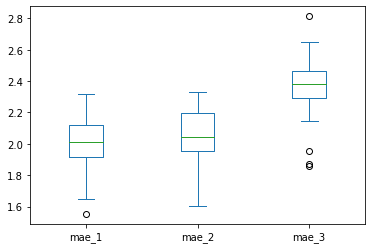

In [17]:
df_res[['mae_1','mae_2','mae_3']].plot.box()

<AxesSubplot:>

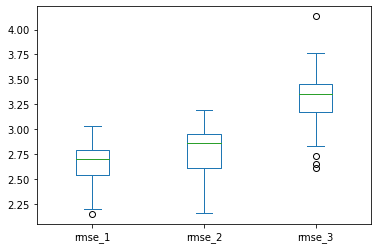

In [18]:
df_res[['rmse_1','rmse_2','rmse_3']].plot.box()

<AxesSubplot:>

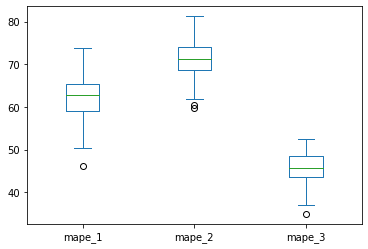

In [19]:
df_res[['mape_1','mape_2','mape_3']].plot.box()

# Prediccion

In [8]:
def predecir():
    models = list()
    rmse_vals = list()
    for i in range(n_iter):
        model = load_model(model_path)
        model.fit(x_train, y_train, validation_split = 0.3, epochs = n_epochs,
                    batch_size = mini_batch, callbacks = [es], shuffle = False, verbose = 0)
        y_pred = model(x_test)
        y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
        dn_y_test = std_scaler_y_test.inverse_transform(y_test)
        dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)
        rmse_vals.append(rmse(dn_y_test, dn_y_pred)[0])
        model.save(res_name+'_'+str(i)+'.h5')
    print('Mejor valor: {}, iter: {}'.format(np.min(rmse_vals), np.argmin(rmse_vals)))
    return np.argmin(rmse_vals)

In [9]:
best_iter = predecir()

Mejor valor: 1.4490718467661285, iter: 27


(3, 12)


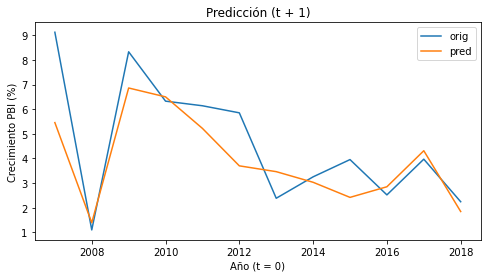

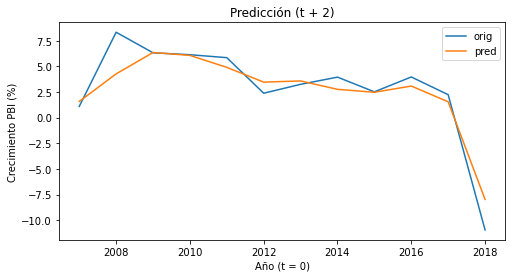

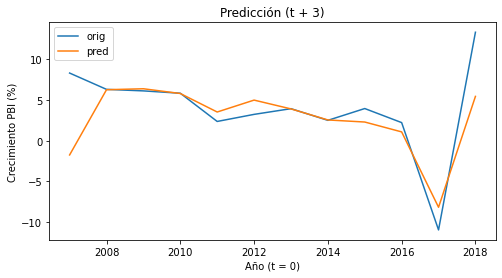

In [10]:
model = load_model(res_name+'_'+str(best_iter)+'.h5')
#model = load_model('resultados/GRU_20220731_1052_7.h5')
y_pred = model(x_test)
y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)
plot_pred(dn_y_test, dn_y_pred,2021)

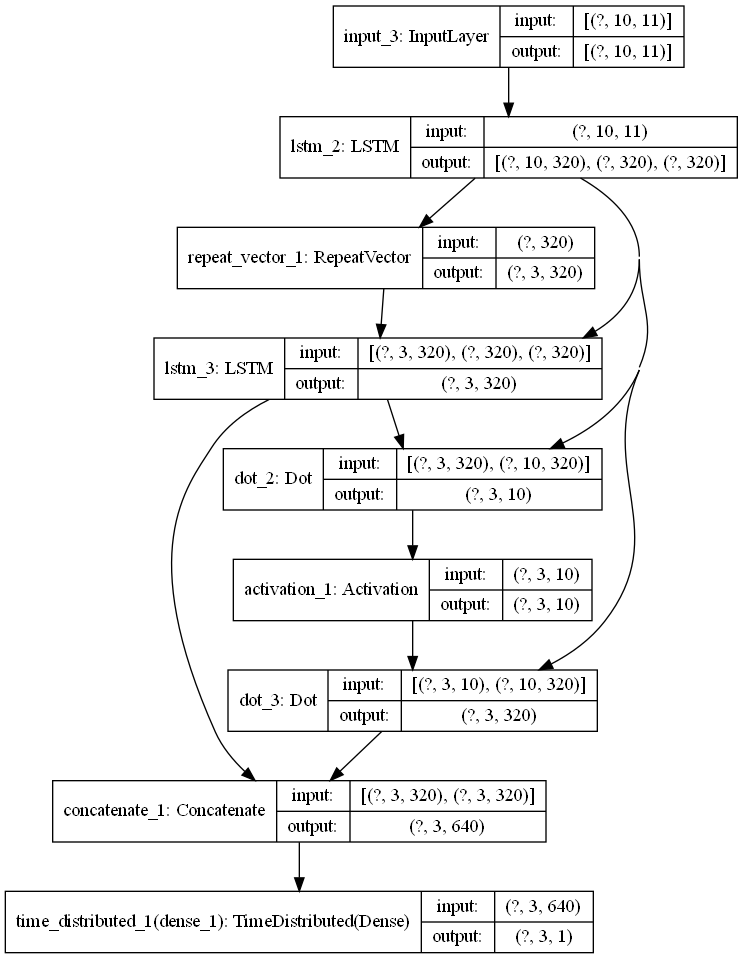

In [18]:
plot_model(model,'Seq2Seq.png',show_shapes=True, show_layer_names=True)

In [19]:
# from notifications import enviar_correo
# enviar_correo("Evaluacion Finalizado!","Se ha completado: {}".format(res_name))